In [1]:
from pathlib import Path
from tokenizer.BPE import Tokenizer
from utils.raw_data import load_wmt_chunk_df, get_wmt_df_len
import numpy as np
import math
from typing import Optional

import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler

from model import Transformer

from torch.utils.data import DataLoader
from utils.dataset import NeuralTranslationDataset

# DEBUG
from matplotlib import pyplot as plt

In [2]:
# load tokenizer
tokenizer = Tokenizer(compute_vocab=False, 
                      max_vocab_size=37_005,
                      corpus_source='wmt',
                      vocab_dest_file=Path('./data/dest/wmt_37k_tokens.yaml'))

In [3]:
# device
device = torch.device('cuda')

In [4]:
# model
transformer = Transformer(N=3, 
                          L=64, 
                          d=512, 
                          h=8, 
                          d_ff=2048,
                          n_vocab=len(tokenizer.token_vocab), 
                          padding_idx=tokenizer.token_vocab['<PAD>'], 
                          bos_idx=tokenizer.token_vocab['<BOS>'], 
                          dtype=torch.float, 
                          device=device)

In [5]:
# criterion
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token_vocab['<PAD>'])

# optimizer
optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-4)

# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

In [6]:
# dataset
data_test = NeuralTranslationDataset(subset='test')

# dataloader
loader = DataLoader(data_test,
                    batch_size=3,
                    shuffle=False,
                    num_workers=4, 
                    pin_memory=True)

In [7]:
loss_list = []
num_epochs = 2
for epoch in range(1, num_epochs+1):
    transformer.train()
    total_loss = 0.0

    # batch
    for batch in loader:
        src = batch['src_ids'].to(device)   # (B, S)
        tgt = batch['tgt_ids'].to(device)   # (B, T)

        # logits
        logits = transformer(src_ids=src, tgt_ids=tgt)

        B, T, V = logits.shape

        # loss
        loss = criterion(logits.view(B*T, V), tgt.view(B*T))
        
        # d) backward + step
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        # plot loss
        loss_list.append(loss.item())

        
    

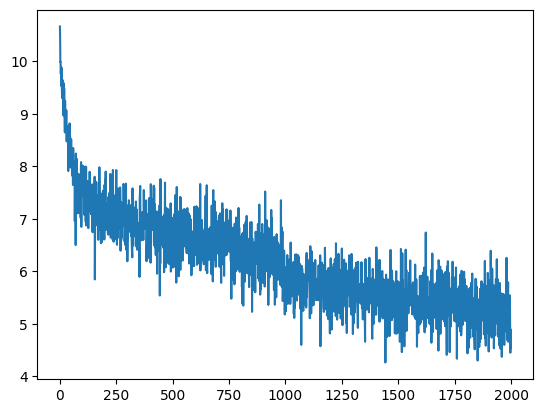

In [9]:
plt.plot(loss_list)